In [1]:
import os
pathDir = "/home/jamiil/Documents/fastai_lesson2_project/" 
os.chdir(pathDir)

In [2]:
!pip install -r requirement.txt  # install required libraries

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#hide
from utils import *
from fastai2.vision.widgets import *

/home/jamiil/.local/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## Getting urls of images to download

To get images url from [Google Images](http://images.google.com). Go to the link and search for an image you are interested in. And then do the following :

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [4]:
ims = ["https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTLG38SkueQskuevslHoO4uBEDRGDPLBpksiefN9DgfjyBA3UL7"]

In [5]:
dest = 'Data/pounded_yam.jpg'
download_url(ims[0], dest)

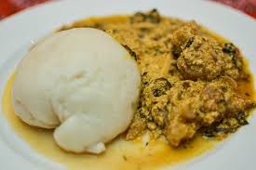

In [6]:
im = Image.open(dest)
im.to_thumb(256,256)

## Download images

In [7]:
food_types = 'yam','cassava','fufu'
path = Path('poundedFood')

In [8]:
food_types = 'yam','cassava','fufu'
path = Path('poundedFood')

In [9]:
doc(download_images)

In [10]:
files = ["Data/urls_pounded_yam.csv",
         "Data/urls_pounded_cassava.csv",
         "Data/urls_fufu.csv"] # obtained those files from getting urls part
if not path.exists():
    path.mkdir()
    for i, o in enumerate(food_types):
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        download_images(dest = dest,
                        url_file = files,
                        urls = [url for url in open(pathDir+files[i])],
                        max_pics = 200)

In [11]:
fns = get_image_files(path)
fns

(#934) [Path('poundedFood/cassava/00000316.jpg'),Path('poundedFood/cassava/00000149.jpg'),Path('poundedFood/cassava/00000133.jpg'),Path('poundedFood/cassava/00000076.jpg'),Path('poundedFood/cassava/00000222.jpg'),Path('poundedFood/cassava/00000164.jpg'),Path('poundedFood/cassava/00000046.jpg'),Path('poundedFood/cassava/00000284.jpg'),Path('poundedFood/cassava/00000256.jpg'),Path('poundedFood/cassava/00000270.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#0) []

In [13]:
failed.map(Path.unlink)

(#0) []

## From Data to DataLoaders

In [14]:
poundedFood = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

In [15]:
dls = poundedFood.dataloaders(path)

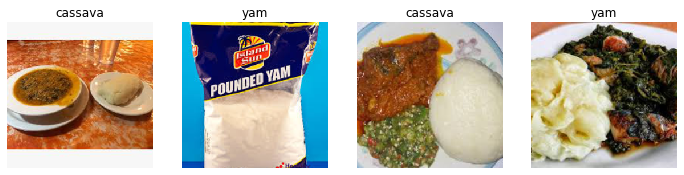

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

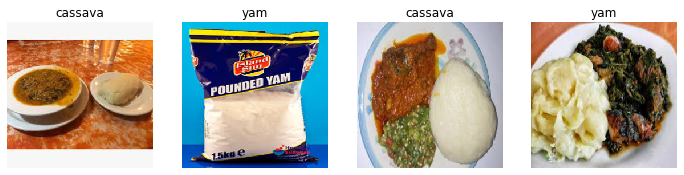

In [17]:
poundedFood = poundedFood.new(item_tfms=Resize(256, ResizeMethod.Squish))
dls = poundedFood.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

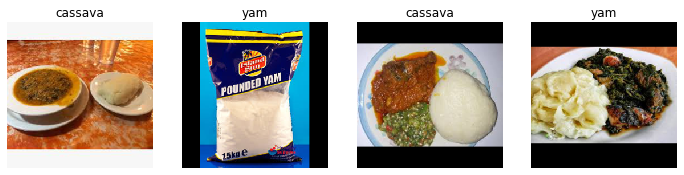

In [18]:
poundedFood = poundedFood.new(item_tfms=Resize(256, ResizeMethod.Pad, pad_mode='zeros'))
dls = poundedFood.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

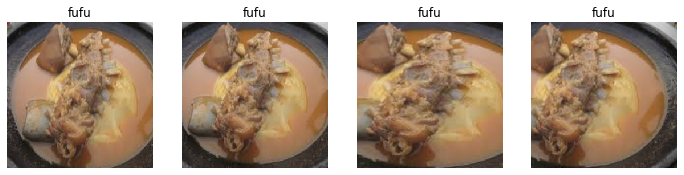

In [19]:
poundedFood = poundedFood.new(item_tfms=RandomResizedCrop(256, min_scale=0.5))
dls = poundedFood.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

## Data Augumentation


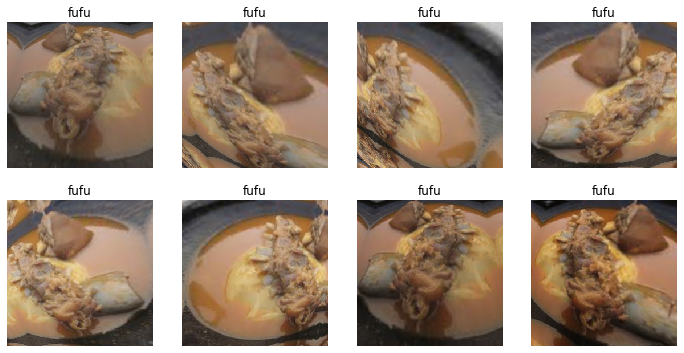

In [20]:
poundedFood = poundedFood.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = poundedFood.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

## Train our model and using it to clean our data

In [21]:
poundedFood = poundedFood.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                              batch_tfms=aug_transforms())
dls = poundedFood.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.918003,1.313662,0.482143,01:09


epoch,train_loss,valid_loss,error_rate,time
0,1.504867,1.118577,0.442857,01:40
1,1.378902,1.087971,0.417857,01:42
2,1.215023,1.184435,0.425000,01:35
3,1.123005,1.157278,0.403571,01:36


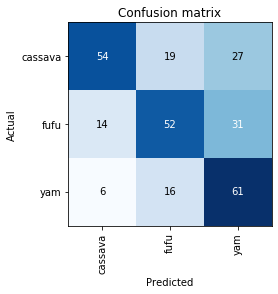

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

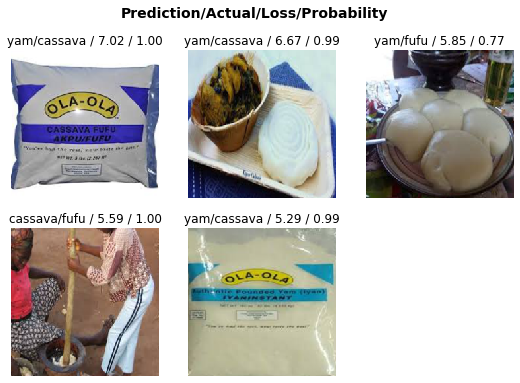

In [24]:
interp.plot_top_losses(5, nrows=2)

In [25]:
doc(ImageClassifierCleaner)

In [26]:
#hide_output
cleaner = ImageClassifierCleaner(learn, max_n = 5)
cleaner

In [27]:
cleaner.delete()

(#0) []

In [28]:
# To delete images where we've selected, we would run:

#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [29]:
#To move images where we've selected a different category, we would run:

#for idx,cat in cleaner.change(): shutil.move(cleaner.fns[idx], path/cat)

## Turning your model into an online application

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict(pathDir+'Data/pounded_yam.jpg')

('yam', tensor(2), tensor([0.0153, 0.0346, 0.9501]))

In [34]:
learn_inf.dls.vocab

(#3) ['cassava','fufu','yam']

## Creating a notebook app from the model

In [35]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['Data/pounded_yam_example.jpg'])

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: yam; Probability: 0.6260')

In [41]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [44]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [45]:
#!pip install voila

In [46]:
#!jupyter serverextension enable voila    #removed and it's worked --sys-prefix